In [4]:
import pandas as pd

import adtk
from adtk.detector import MinClusterDetector
from adtk.data import validate_series
from adtk.visualization import plot

from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN

from pyod.models.knn import KNN
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

import pickle

In [7]:
# temperature testing data
df = pd.read_csv("temp.csv")

In [8]:
df.head()

,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


## ADTK

https://www.influxdata.com/blog/birch-for-anomaly-detection-with-influxdb/  
https://arundo-adtk.readthedocs-hosted.com/en/stable/

In [9]:
df = pd.read_csv('temp.csv', index_col="timestamp", parse_dates=True, squeeze=False)
s_train = validate_series(df["value"])
s_train

timestamp
2013-07-04 00:00:00    69.880835
2013-07-04 01:00:00    71.220227
2013-07-04 02:00:00    70.877805
2013-07-04 03:00:00    68.959400
2013-07-04 04:00:00    69.283551
                         ...    
2014-05-28 11:00:00    72.370206
2014-05-28 12:00:00    72.172956
2014-05-28 13:00:00    72.046565
2014-05-28 14:00:00    71.825226
2014-05-28 15:00:00    72.584089
Name: value, Length: 7267, dtype: float64

[<AxesSubplot:>]

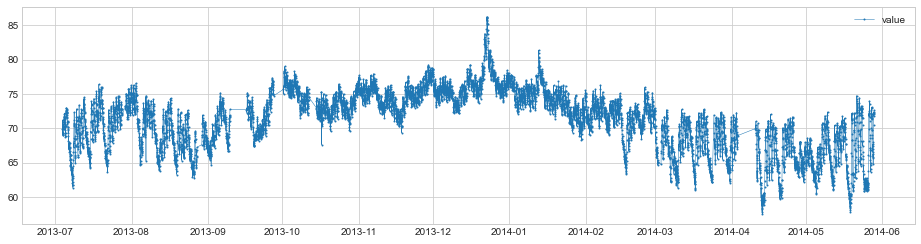

In [10]:
plot(s_train)

In [11]:
df = pd.read_csv('temp.csv', index_col="timestamp", parse_dates=True, squeeze=False)
df = validate_series(df)

## ADTK with KMeans

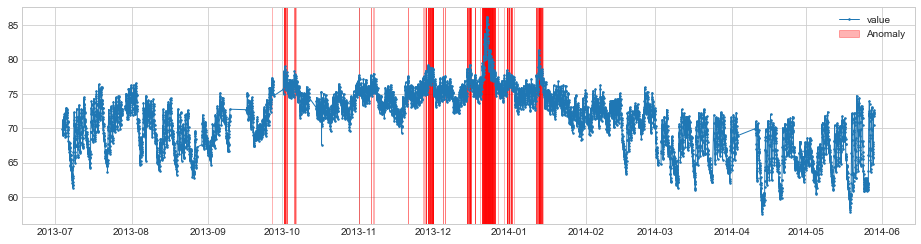

In [12]:
min_cluster_detector = MinClusterDetector(KMeans(n_clusters=7))
anomalies = min_cluster_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

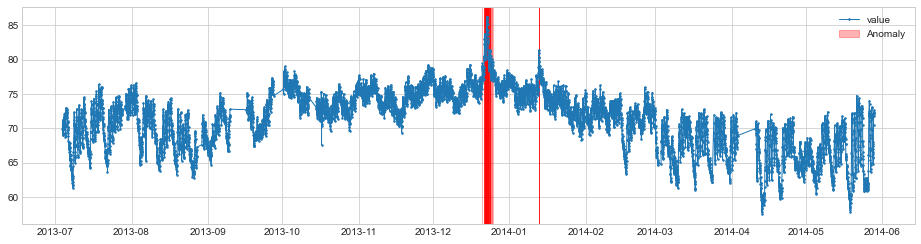

In [13]:
min_cluster_detector = MinClusterDetector(KMeans(n_clusters=8))
anomalies = min_cluster_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all');

## ADTK With Birch
(balanced iterative reducing and clustering using hierarchies)

#### With n_clusters=2

[<AxesSubplot:>]

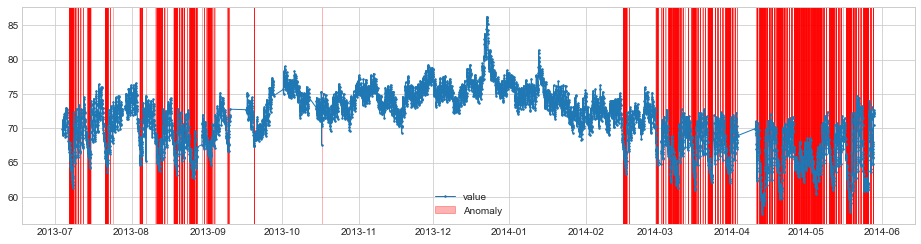

In [14]:
df = pd.read_csv('temp.csv', index_col="timestamp", parse_dates=True, squeeze=False)
df = validate_series(df)
min_cluster_detector = MinClusterDetector(Birch(n_clusters=2))
anomalies = min_cluster_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

#### With n_clusters = 3

[<AxesSubplot:>]

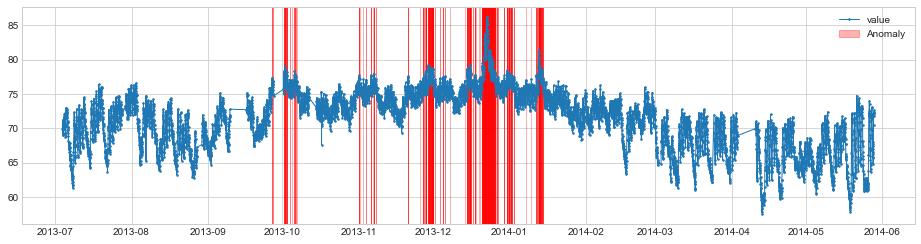

In [19]:
df = pd.read_csv('temp.csv', index_col="timestamp", parse_dates=True, squeeze=False)
df = validate_series(df)
min_cluster_detector = MinClusterDetector(Birch(n_clusters=3))
anomalies = min_cluster_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

#### ADTK interfaces easily with most sk-learn models

## Create, save, load sk-learn models for ADTK

Create the model

[<AxesSubplot:>]

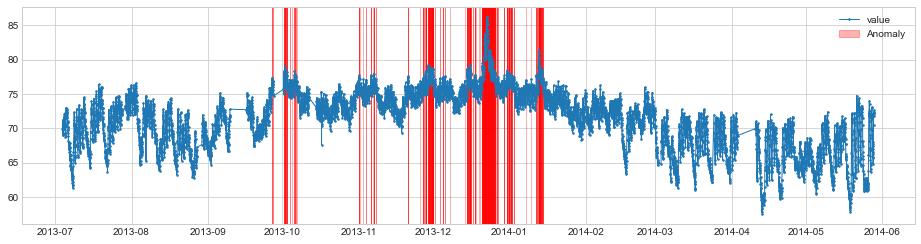

In [133]:
df = pd.read_csv('temp.csv', index_col="timestamp", parse_dates=True, squeeze=False)
df = validate_series(df)
min_cluster_detector = MinClusterDetector(Birch(n_clusters=3))
anomalies = min_cluster_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

Save the model

In [139]:
# save the model to disk
filename = 'saved_model.sav'
pickle.dump(min_cluster_detector.model, open(filename, 'wb'))
 
min_cluster_detector.model = None

Test that the model fails

In [140]:
try:
    anomalies = min_cluster_detector.detect(df)
except:
    print("successfully failed")

successfully failed


Load the model

[<AxesSubplot:>]

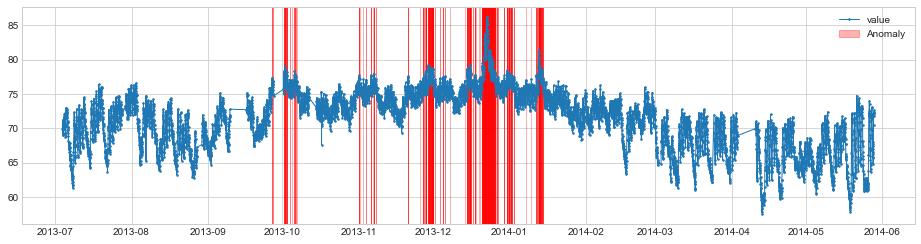

In [141]:
# load the model from disk
model = pickle.load(open(filename, 'rb'))
min_cluster_detector.model = model

anomalies = min_cluster_detector.detect(df)
plot(df, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

## PyOD

Contains many implemented algroithms:
https://pyod.readthedocs.io/en/latest/#implemented-algorithms

In [21]:
df = pd.read_csv('temp.csv', index_col="timestamp", parse_dates=True, squeeze=False)
X = df.values

# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores


In [22]:
sum(y_train_pred)/len(X)

0.10004128250997661

In [23]:
anomaly_indexs = list(np.where(y_train_pred == 1))[0]

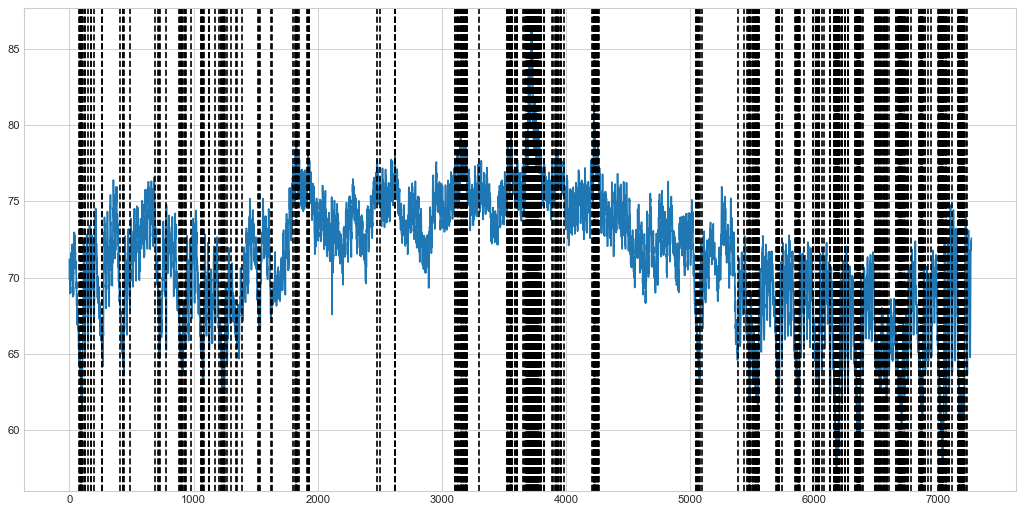

In [24]:
figure(figsize=(16, 8), dpi=80)

plt.plot(X)
for xc in anomaly_indexs:
    plt.axvline(x=xc, color='k', linestyle='--')

## Microsoft Azure Anomaly Detection

In [40]:
import os
from azure.ai.anomalydetector import AnomalyDetectorClient
from azure.ai.anomalydetector.models import DetectRequest, TimeSeriesPoint, TimeGranularity, \
    AnomalyDetectorError
from azure.core.credentials import AzureKeyCredential
import pandas as pd

In [41]:
SUBSCRIPTION_KEY = os.environ["ANOMALY_DETECTOR_KEY"]
ANOMALY_DETECTOR_ENDPOINT = os.environ["ANOMALY_DETECTOR_ENDPOINT"]
TIME_SERIES_DATA_PATH = os.path.join("./", "temp.csv")

In [42]:
client = AnomalyDetectorClient(AzureKeyCredential(SUBSCRIPTION_KEY), ANOMALY_DETECTOR_ENDPOINT)

In [43]:
import datetime
from datetime import timezone, datetime

# 3rd party modules
import pandas as pd
import pytz

df = pd.read_csv('temp.csv', squeeze=False, encoding='utf-8', date_parser=[0])
df.timestamp = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

df['timestamp'] = pd.to_datetime(df.timestamp, format='%Y-%m-%d %H:%M:%S')

print(df.head())
print(df.dtypes)

df['timestamp'] = df['timestamp'].dt.tz_localize(timezone.utc)

# Convert the time from to another timezone
# The point in time does not change, only the associated timezone
my_timezone = pytz.timezone('Canada/Pacific')
df['timestamp'] = df['timestamp'].dt.tz_convert(my_timezone)


print(df.head())
print(df.dtypes)

            timestamp      value
0 2013-07-04 00:00:00  69.880835
1 2013-07-04 01:00:00  71.220227
2 2013-07-04 02:00:00  70.877805
3 2013-07-04 03:00:00  68.959400
4 2013-07-04 04:00:00  69.283551
timestamp    datetime64[ns]
value               float64
dtype: object
                  timestamp      value
0 2013-07-03 17:00:00-07:00  69.880835
1 2013-07-03 18:00:00-07:00  71.220227
2 2013-07-03 19:00:00-07:00  70.877805
3 2013-07-03 20:00:00-07:00  68.959400
4 2013-07-03 21:00:00-07:00  69.283551
timestamp    datetime64[ns, Canada/Pacific]
value                               float64
dtype: object


In [44]:
series = []


from dateutil.tz import tzutc
from dateutil.parser import parse

def parse_date_string(x):
    s = x.split(" ")
    return s[0]+"T"+s[1]+"Z"

data_file = pd.read_csv("temp.csv", encoding='utf-8', date_parser=[0])
data_file["timestamp"] = data_file["timestamp"].apply(parse_date_string)
print(data_file.head())

data_file.timestamp = pd.to_datetime(data_file['timestamp'], format='%Y-%m-%dT%H:%M:%SZ')

data_file["timestamp"] = data_file["timestamp"].dt.strftime('%Y-%m-%dT%H:%M:%SZ')


print(data_file.head())

for index, row in data_file.iterrows():
    series.append(TimeSeriesPoint(timestamp=row[0], value=row[1]))


              timestamp      value
0  2013-07-04T00:00:00Z  69.880835
1  2013-07-04T01:00:00Z  71.220227
2  2013-07-04T02:00:00Z  70.877805
3  2013-07-04T03:00:00Z  68.959400
4  2013-07-04T04:00:00Z  69.283551
              timestamp      value
0  2013-07-04T00:00:00Z  69.880835
1  2013-07-04T01:00:00Z  71.220227
2  2013-07-04T02:00:00Z  70.877805
3  2013-07-04T03:00:00Z  68.959400
4  2013-07-04T04:00:00Z  69.283551


In [45]:
request = DetectRequest(series=series, granularity=TimeGranularity.hourly)

In [46]:
print(data_file.dtypes)

timestamp     object
value        float64
dtype: object


In [47]:
print('Detecting anomalies in the entire time series.')

try:
    response = client.detect_entire_series(request)
except Exception as e:
    print(e)

anomaly_indexes = []
if any(response.is_anomaly):
    print('An anomaly was detected at index:')
    for i, value in enumerate(response.is_anomaly):
        if value:
            print(i)
            anomaly_indexes.append(i)
else:
    print('No anomalies were detected in the time series.')

Detecting anomalies in the entire time series.
An anomaly was detected at index:
780
2115
3558
3559
3561
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
4223
4224
4225
4226
4227
4228
4230
4231
4233
4234
4236
4237
7097
7098
7099
7120
7122


              timestamp      value
0  2013-07-04T00:00:00Z  69.880835
1  2013-07-04T01:00:00Z  71.220227
2  2013-07-04T02:00:00Z  70.877805
3  2013-07-04T03:00:00Z  68.959400
4  2013-07-04T04:00:00Z  69.283551
Index(['timestamp', 'value'], dtype='object')


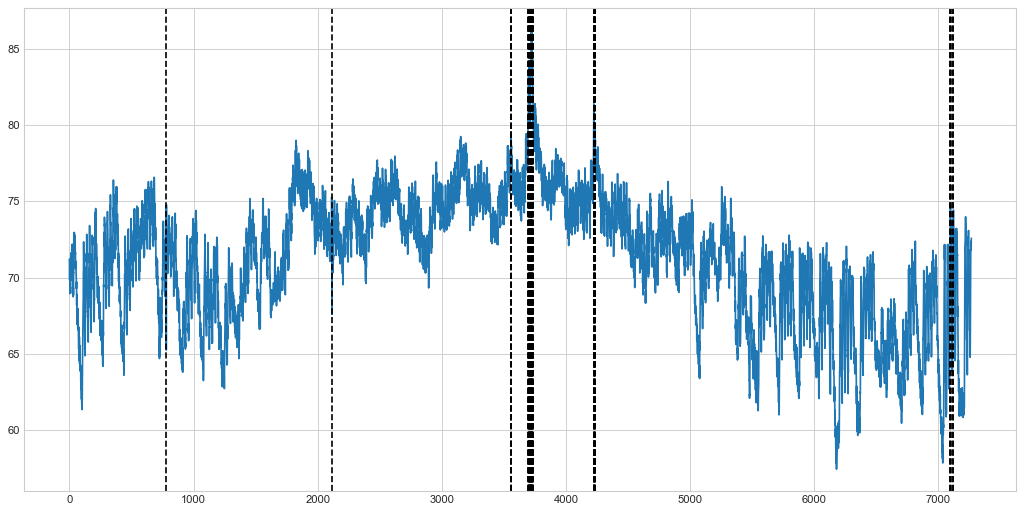

In [48]:
print(data_file.head())
figure(figsize=(16, 8), dpi=80)
print(data_file.columns)
plt.plot(data_file["value"])
for xc in anomaly_indexes:
    plt.axvline(x=xc, color='k', linestyle='--')

In [36]:
print('Detecting the anomaly status of the latest data point.')

try:
    response = client.detect_last_point(request)
except AnomalyDetectorError as e:
    print('Error code: {}'.format(e.error.code), 'Error message: {}'.format(e.error.message))
except Exception as e:
    print(e)

if response.is_anomaly:
    print('The latest point is detected as anomaly.')
else:
    print('The latest point is not detected as anomaly.')

Detecting the anomaly status of the latest data point.
The latest point is not detected as anomaly.


In [51]:
print('Detecting change points in the entire time series.')

anomalies = []
try:
    response = client.detect_change_point(request)
except AnomalyDetectorError as e:
    print('Error code: {}'.format(e.error.code), 'Error message: {}'.format(e.error.message))
except Exception as e:
    print(e)

if any(response.is_change_point):
    print('An change point was detected at index:')
    for i, value in enumerate(response.is_change_point):
        if value:
            print(i)
            anomalies.append(i)
else:
    print('No change point were detected in the time series.')

Detecting change points in the entire time series.
An change point was detected at index:
744
1294
2410
2981
3670
5188
5550
6430
6749
7237


              timestamp      value
0  2013-07-04T00:00:00Z  69.880835
1  2013-07-04T01:00:00Z  71.220227
2  2013-07-04T02:00:00Z  70.877805
3  2013-07-04T03:00:00Z  68.959400
4  2013-07-04T04:00:00Z  69.283551
Index(['timestamp', 'value'], dtype='object')


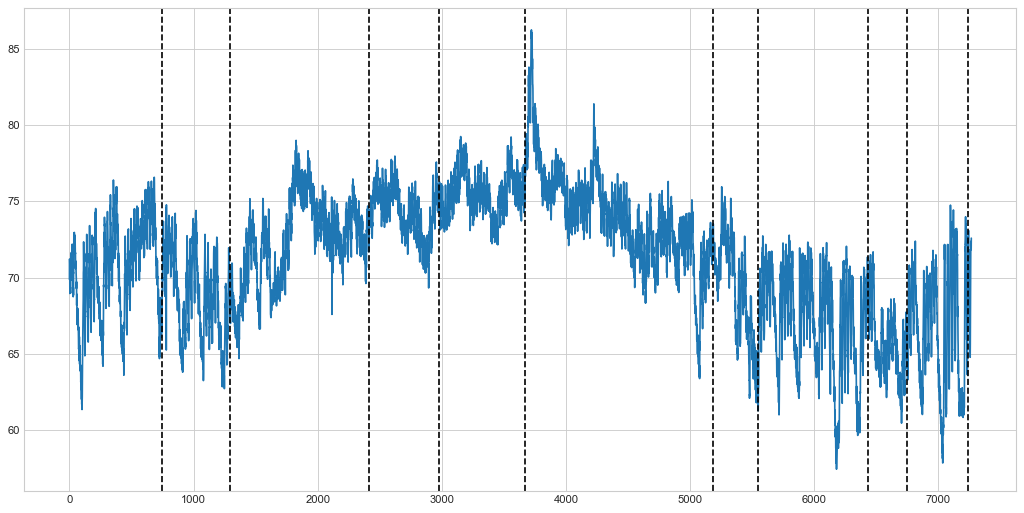

In [53]:
print(data_file.head())
figure(figsize=(16, 8), dpi=80)
print(data_file.columns)
plt.plot(data_file["value"])
for xc in anomalies:
    plt.axvline(x=xc, color='k', linestyle='--')

Microsoft Azure Anomaly Detection works nicely and easily (except for specific time stamp formatting)  
Evaluation metrics remain untested for now.

But cannot use azure's api because it requires credits, looking into implementing microsoft's sr-cnn from the source code.